In [1]:
import os 
import zipfile 

import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D, MaxPool2D, Lambda
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torchvision
import torchvision.transforms as transforms

import glob
from PIL import Image

from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from IPython.display import clear_output
from tqdm import tqdm

from sklearn.metrics import confusion_matrix
import seaborn as sns

from keras import backend as K

from sklearn.utils import resample

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
data_dir = "images/"
metadata_path = "HAM10000_metadata.csv"

In [3]:
#Lesion Dictionary
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [4]:
# Read metadata into dataframe
metadata = pd.read_csv(metadata_path)
skin_df = metadata

In [5]:
# Dictionary for Image Names
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob.glob(os.path.join(data_dir, '*.jpg'))}

In [6]:
#Create useful Columns - Images Path, Lesion Type and Lesion Categorical Code
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [7]:
# Lesion code dictionary
lesion_code_dict = pd.Series(skin_df.dx.values,index=skin_df.cell_type_idx).to_dict()

lesion_code_dict

{2: 'bkl', 4: 'nv', 3: 'df', 5: 'mel', 6: 'vasc', 1: 'bcc', 0: 'akiec'}

In [8]:
skin_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,images\ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,images\ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,images\ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,images\ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,images\ISIC_0031633.jpg,Benign keratosis-like lesions,2
...,...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern,images\ISIC_0033084.jpg,Actinic keratoses,0
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern,images\ISIC_0033550.jpg,Actinic keratoses,0
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern,images\ISIC_0033536.jpg,Actinic keratoses,0
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern,images\ISIC_0032854.jpg,Actinic keratoses,0


In [9]:
# Attach images to the skin_df Dataframe
temp_arr, count = [], 0
for path in tqdm(skin_df['path']):
  temp_arr.append(np.asarray( Image.open(path).resize((224,224)) ))
  count += 1
  # print(f"Processed images: {count}")
  # if count % 10 == 0: clear_output()

skin_df['image'] = temp_arr


# skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10015/10015 [06:30<00:00, 25.66it/s]


In [10]:
# Separate the dataframe into Features and Targets data
features = skin_df.drop(columns=['cell_type_idx','dx'],axis=1)
target = skin_df['cell_type_idx']

In [11]:
# Create First Train and Test sets
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20, random_state=1)
print(x_train_o.shape)
print(y_train_o.shape)

(8012, 10)
(8012,)


In [12]:
# Create image arrays from the train and test sets
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

print(x_train.shape)
print(x_test.shape)

(8012, 224, 224, 3)
(2003, 224, 224, 3)


In [13]:
# Class distribution before data augmentation
train_value_counts = y_train_o.value_counts()
print(train_value_counts)
print(f'Total images: {train_value_counts.sum()}')

4    5378
5     891
2     871
1     418
0     266
6     110
3      78
Name: cell_type_idx, dtype: int64
Total images: 8012


In [14]:
# Data Augmentation
# Image data generator is used to generate the possible versions of data as given below.

dataaugment = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        shear_range = 10
    ) 

In [15]:
# For each lesion code != 4, get the indices in y_train_o.
# For the same indices in x_train_o, augment the image present in the row.
reset_y_train_o = y_train_o.reset_index(drop=True)
reset_index = reset_y_train_o.index

print(len(y_train_o))

8012


In [ ]:
# The normalisation is done using the training set Mean and Std. Deviation as reference
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

print(f'x_train_mean: {x_train_mean}')
print(f'x_train_std: {x_train_std}')

In [ ]:
# MAY HANG
x_train = (x_train - x_train_mean) / x_train_std
x_test = (x_test - x_train_mean) / x_train_std

In [18]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [19]:
# Splitting training into Train and Validatation sets
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state=1)

# Reshaping the Images into 3 channels (RGB)
# height = 75, width = 100, canal = 3
x_train = x_train.reshape(x_train.shape[0], *(224, 224, 3))
x_test = x_test.reshape(x_test.shape[0], *(224, 224, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(224, 224, 3))

In [4]:
vgg16 = VGG16(input_shape=[224, 224] + [3], weights='imagenet', include_top=False)

for layer in vgg16.layers:
    layer.trainable = False
    
x = Flatten()(vgg16.output)

prediction = Dense(7, activation='softmax')(x)

model = Model(inputs=vgg16.input, outputs=prediction)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [21]:
# Define metrics 

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [22]:
# New baseline
# Define the optimizer
optimizer = Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy", f1_m,precision_m, recall_m])

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
early_stopping_monitor = EarlyStopping(patience=20,monitor='val_accuracy')

In [23]:
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_validate = np.asarray(x_validate)
y_validate = np.asarray(y_validate)

In [26]:
# Fit the model

epochs = 20
batch_size = 10
history = model.fit(dataaugment.flow(x_train,y_train, batch_size=batch_size),
                    epochs = epochs, validation_data = (x_validate,y_validate),
                    verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

# history = model.fit(x=x_train, y=y_train,
#                               epochs = epochs, validation_data = (x_validate,y_validate),
#                               verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
#                               , callbacks=[learning_rate_reduction])

Epoch 1/20
721/721 [==============================] - 1163s 2s/step - loss: 1.1456 - accuracy: 0.6702 - f1_m: 0.6650 - precision_m: 0.6731 - recall_m: 0.6627 - val_loss: 1.1226 - val_accuracy: 0.6808 - val_f1_m: 0.6743 - val_precision_m: 0.6743 - val_recall_m: 0.6743
Epoch 2/20
721/721 [==============================] - 1192s 2s/step - loss: 1.1349 - accuracy: 0.6702 - f1_m: 0.6702 - precision_m: 0.6702 - recall_m: 0.6702 - val_loss: 1.1204 - val_accuracy: 0.6808 - val_f1_m: 0.6743 - val_precision_m: 0.6743 - val_recall_m: 0.6743
Epoch 3/20
721/721 [==============================] - 1214s 2s/step - loss: 1.1310 - accuracy: 0.6702 - f1_m: 0.6702 - precision_m: 0.6702 - recall_m: 0.6702 - val_loss: 1.1234 - val_accuracy: 0.6808 - val_f1_m: 0.6743 - val_precision_m: 0.6743 - val_recall_m: 0.6743
Epoch 4/20
721/721 [==============================] - 1187s 2s/step - loss: 1.1333 - accuracy: 0.6702 - f1_m: 0.6702 - precision_m: 0.6702 - recall_m: 0.6702 - val_loss: 1.1315 - val_accuracy: 0.6

KeyboardInterrupt: 

dict_keys(['loss', 'accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m', 'lr'])
Accuracy: 0.8999999761581421
loss: 0.5843114256858826
f1_m: 0.8999999165534973
precision_m: 0.8999999761581421
recall_m: 0.8999999761581421


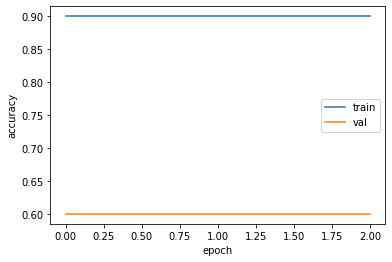

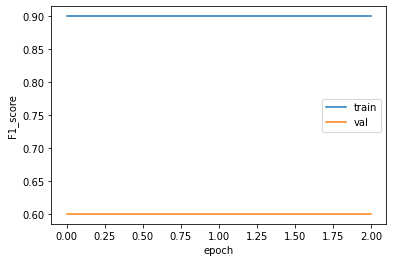

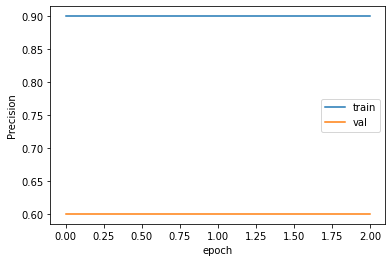

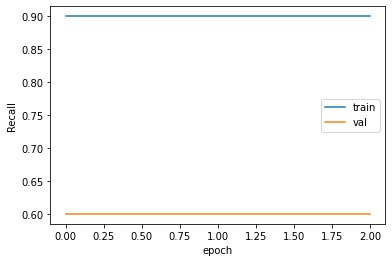

In [49]:
# plot graphs from history
print(history.history.keys())
print(f'Accuracy: {history.history["accuracy"][-1]}')
print(f'loss: {history.history["loss"][-1]}')
print(f'f1_m: {history.history["f1_m"][-1]}')
print(f'precision_m: {history.history["precision_m"][-1]}')
print(f'recall_m: {history.history["recall_m"][-1]}')

plt.plot(history.history["accuracy"], label='accuracy')
plt.plot(history.history["val_accuracy"], label='Validaion accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

plt.plot(history.history["f1_m"], label='F1_score')
plt.plot(history.history["val_f1_m"], label='Validaion F1_score')
plt.ylabel('F1_score')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

plt.plot(history.history["precision_m"], label='Precision')
plt.plot(history.history["val_precision_m"], label='Validaion Precision')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

plt.plot(history.history["recall_m"], label='Recall')
plt.plot(history.history["val_recall_m"], label='Validaion Recall')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

In [43]:
# Evaluate model
test_eval = model.evaluate(x_test, y_test, verbose=1, return_dict=True)
validation_eval = model.evaluate(x_validate, y_validate, verbose=1, return_dict=True)
# model.save("model.h5")

 4/63 [>.............................] - ETA: 2:15 - loss: 1.2023 - accuracy: 0.6641 - f1_m: 0.6641 - precision_m: 0.6641 - recall_m: 0.6641

KeyboardInterrupt: ignored

In [ ]:
for i, j in validation_eval.items():
    print(f'{i}: {j}')

loss: 0.6498839855194092
accuracy: 0.748129665851593
f1_m: 0.7310635447502136
precision_m: 0.860512375831604
recall_m: 0.6394230723381042


In [ ]:
for i, j in test_eval.items():
    print(f'{i}: {j}')

loss: 0.7060219049453735
accuracy: 0.7413879036903381
f1_m: 0.7320070266723633
precision_m: 0.8558425903320312
recall_m: 0.6424916386604309


In [ ]:
# Get predictions for plotting the confusion matrix
predictions = model.predict(x_test, verbose=1)

63/63 [==============================] - 12s 194ms/step


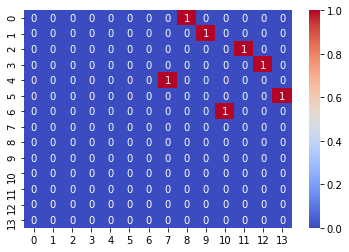

In [ ]:
# Plot the confusion matrix
predictions = np.argmax(predictions, axis=0)
y_test = np.argmax(y_test, axis=0)

sns.heatmap(confusion_matrix(y_test, predictions), annot=True, cmap = 'coolwarm', fmt='.0f')
plt.show()

# Model Parameters
input_shape = (75, 100, 3)

# Number of classes
num_classes = 7

# Optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

# Epoch is number of times a node is trained
epochs = 9
batch_size = 20

# Callback functions (To follow the path of gradient descent)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=0, factor=0.5, min_lr=0.00001)
early_stopping_monitor = EarlyStopping(patience=20, monitor='val_accuracy')


# dataaugment.flow(x_train,y_train, batch_size=batch_size),
# callbacks=[learning_rate_reduction,early_stopping_monitor]
history = model.fit(
    x = x_train,
    y = y_train, 
    batch_size=batch_size,
    verbose = 0, 
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=10,
    validation_data = (x_validate, y_validate)
)

loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
predictions = model.predict(x_test)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=0)
loss_t, accuracy_t = model.evaluate(x_train, y_train, verbose=0)

print("Training: accuracy = %f" % (accuracy_t))
print("Validation: accuracy = %f" % (accuracy_v))
print("Test: accuracy = %f" % (accuracy))

predictions = np.argmax(predictions, axis=1)

y_test = np.argmax(y_test, axis=1)


sns.heatmap(confusion_matrix(y_test, predictions), annot=True, cmap = 'coolwarm', fmt='.0f')
plt.show()

len(predictions)

target.value_counts()
len(x_train)
len(x_validate)